# NLP - Assignment 3
## Paarth Iyer - MCS202218

In [2]:
## for kaggle
# !mkdir epoch_checkpoints

In [1]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [2]:
# setting device to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I have written a custom dataset class which outputs sequences of a given length along with the next word to be predicted. Sequences are generated by taking a window length of the sequence and that is then moved on the dataset to obtain the samples. If an abstract is smaller than the sequence length, it is dropped. Not many are dropped when taking sequence length to be 40 or 50. It is also given a window skip parameter, which skips that many number of words to get the next sequence. This helps reduce the training data while not losing too much information.

In [3]:
class TextDataset(Dataset):
    def __init__(self, file, seq_length, window_skip):
        self.seq_len = seq_length
        self.window_skip = window_skip
        self.lines = self.load_lines(file)

        self.vocab = self.uniq_words()
        # make dictionaries for word to idx and inverse
        self.idx_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_idx = {word: index for index, word in enumerate(self.vocab)}

        # converts all the lines with words to lines with indices of the word
        self.lines_indices = [[self.word_to_idx[x] for x in line] for line in filter(lambda x: len(x)>self.seq_len,self.lines)]

        self.converted_idx = self.index_convert()
        self.total_seq = len(self.converted_idx)

    # loads the given file and adds start and enf markers to the them
    def load_lines(self, file):
        with open(file) as f:
            lines = f.readlines()
        lines = [["<s>"]+line.split(" ")+["</s>"] for line in lines]
        return lines

    # extracts the unique words from the corpus and sorts them to build a vocabulary and give them indices
    def uniq_words(self):
        counts = Counter()
        list(map(lambda x: counts.update(x), self.lines))
        return sorted(counts, key=counts.get, reverse=True)

    # creates an auxillary array so that when asked for the ith sequence, it returns the index in terms of the
    # index in the list of the abstracts. This way we don't have to coonstruct all the sequences and helps with
    # reducing the space usage
    def index_convert(self):
        ls = []
        for a,b in enumerate(self.lines_indices):
            p = len(b)-self.seq_len-1
            seqs = list(range(0, p+1, self.window_skip))
            if p%self.window_skip != 0:
                seqs.append(p)
            ls.extend(zip([a]*len(seqs), seqs))
        return ls
            
    # size of vocab
    def vocab_size(self):
        return len(self.vocab)

    # requeired functions for dataset class
    def __len__(self):
        return len(self.converted_idx)
    
    # returns the ith index in terms of an input and expected output, both as torch tensors
    def __getitem__(self, index):
        return (torch.tensor(self.lines_indices[self.converted_idx[index][0]][self.converted_idx[index][1]:(self.converted_idx[index][1]+self.seq_len)]),
                torch.tensor(self.lines_indices[self.converted_idx[index][0]][(self.converted_idx[index][1]+1):(self.converted_idx[index][1]+self.seq_len+1)]))


The dataset will be constructed with 40 length sequences and sliding the window over 4 words everytime

In [13]:
# test_dat = TextDataset("/kaggle/input/covid-abstracts-full-stripped/corpus.txt", 40, 4)
test_dat = TextDataset("corpus.txt", 40, 4)

In [14]:
# an example of the 1341th sequence in the dataset
" ".join([test_dat.idx_to_word[x] for x in torch.Tensor.tolist(test_dat[1341][1])])

'that the two cohorts targeted different populations . it should also be noted that the prevalence of positive test results for sars-cov- either by rt-pcr or lus might be affected by a small population size community transmission rates the testing'

The model encoder is an embedding layer followed by 2 layers of bidirectional LSTMs.

The decodes is simply a dense layer which outputs a vocab_size length vector which can be softmaxed to find the next word.

In [15]:
class BiLSTM(nn.Module):
    def __init__(self, dataset):
        super(BiLSTM, self).__init__()
        self.embedding_dims = 256
        self.lstm_size = 128
        self.num_layers = 2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seq_len = dataset.seq_len

        self.vocab_size = dataset.vocab_size()

        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size, 
            embedding_dim=self.embedding_dims)
        
        self.LSTM = nn.LSTM(
            input_size = self.embedding_dims,
            hidden_size = self.lstm_size,
            num_layers= self.num_layers,
            bidirectional = True
        )

        # Decoder
        # has 2*lstm_size as input because of the bidirectional LSTM
        self.fc = nn.Linear(2*self.lstm_size, self.vocab_size)

    # the forward takes in the input and a previous state if we want to predict multiple words
    def forward(self, x, prev_state):
        embeded = self.embedding(x)
        out, new_state = self.LSTM(embeded, prev_state)
        out = self.fc(out)

        return out, new_state


    def init_state(self, max_length):
        # initialize h_0 and c_0 to zeros for prediction
        return (torch.zeros(self.num_layers * 2, max_length, self.lstm_size),torch.zeros(self.num_layers * 2, max_length, self.lstm_size))


In [16]:
# create the model and store it to device
bilstm = BiLSTM(test_dat).to(device)
bilstm

BiLSTM(
  (embedding): Embedding(51829, 256)
  (LSTM): LSTM(256, 128, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=51829, bias=True)
)

In [10]:
# the training loop
# this can simulate batches by splitting the batchs and accumulating losses. reduces GPU memory usage
# simulate batches code is currently commented out for faster training on kaggle GPU
def train(dataset, model, batch_size, epochs, simulate_batches=1):
    
    batch_size = int(batch_size/simulate_batches)

    #randomly splitting data to form a test and train dataloader
    proportions = [.95, .05]
    lengths = [int(p * len(test_dat)) for p in proportions]
    lengths[-1] = len(test_dat) - sum(lengths[:-1])
    
    train_set, test_set = random_split(dataset, lengths)
    train_loader = DataLoader(train_set, batch_size = batch_size)
    test_loader = DataLoader(test_set, batch_size = batch_size)

    # using ADAM optimizer and CrossEntropyLoss for training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()

    # to convert some calculations to fp16 to make the training faster
    scaler = torch.cuda.amp.GradScaler()

    # storing the losses for each batch and then for the epochs
    losses = []
    epoch_loss = []
    validation_loss = []
    validation_losses = []


    for epoch in range(epochs):
        # set model to training mode
        model.train()
        optimizer.zero_grad()
        print({ 'epoch': epoch})

        for batch, (x,y) in tqdm(enumerate(train_loader), total =len(train_loader)):
            # load input and expected output to device
            x, y = x.to(device), y.to(device)

            #for fp16 calculations
            with torch.cuda.amp.autocast(dtype=torch.float16):
                # predict
                y_pred, (a,b) = model(x, None)
                #detach the hidden and cell states from gradient graph
                a.detach()
                b.detach()
                #calculate loss
                loss = criterion(y_pred.transpose(1,2), y)
            
            # backprop step
            scaler.scale(loss).backward()
            # if batch%simulate_batches==0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            #store the batch loss
            epoch_loss.append(loss.item())
        print('epoch : ', epoch, 'completed | ', 'loss :', loss.item())
        #store the epoch losses
        losses.append(epoch_loss)
        epoch_loss = []

        # put the mdoel on eval mode for testing
        model.eval()
        
        print("\nCalculating validation loss for the epoch")

        #calculate the test losses
        for (x,y) in tqdm(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x, None)
            loss = criterion(y_pred.transpose(1,2), y)
            validation_loss.append(loss.item())
        validation_losses.append(validation_loss)
        validation_loss = []
            
        #saving each epoch model
        # torch.save(model.state_dict(), "/kaggle/working/epoch_checkpoints/epoch_"+str(epoch)+".pt")
        torch.save(model.state_dict(), "epoch_checkpoints/epoch_"+str(epoch)+".pt")
        
    return (losses, validation_losses)

In [11]:
torch.cuda.empty_cache()

Training with a batch size of 128 for 15 epochs. This took approximately 10 hours on the whole dataset on the kaggle GPU.

In [ ]:
losses = train(test_dat, bilstm, 128, 15)
# the tqdm output is removed as it was very large

In [14]:
# saving the model
torch.save(bilstm.state_dict(), "lstm_model.pt")

In [15]:
# saving the losses
with open("losses.pkl","wb") as f:
    pickle.dump(losses,f)

In [7]:
with open("losses.pkl", "rb") as f:
    losses = pickle.load(f)

Text(0, 0.5, 'loss')

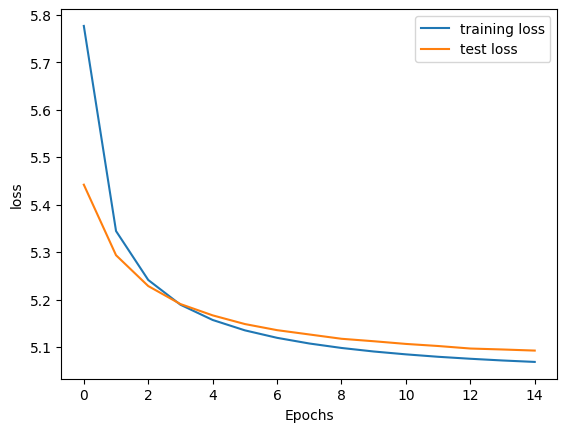

In [9]:
validation = losses[1]
avg_val = [np.mean(x) for x in validation]
training = losses[0]
avg = [np.mean(x) for x in training]

plt.plot(range(15), avg)
plt.plot(range(15), avg_val)
plt.legend(["training loss", "test loss"], loc="upper right")

plt.xlabel("Epochs")
plt.ylabel("loss")

The training loss and test loss decrease. For the first few epochs it seems like the test loss is lower than the training loss, but after 3 epochs it is not the case. The loss is still high, loss could've been lower if the LSTM was larger and had more epochs to run it.

In [ ]:
# to zip the files on kaggle
# !zip -r small_test.zip /kaggle/working

In [ ]:
# creates a downloadable link for the file on kaggle
# from IPython.display import FileLink
# FileLink(r'small_test.zip')

In [28]:
# a function to predict the next few words given a seed
def predict(dataset, model, text, max_words=100):
    model.to('cpu').eval()

    words = text.split(' ')
    # initializing hidden and cell states
    state_h, state_c = model.init_state(len(words))

    for i in range(0, max_words):
        x = torch.tensor([[dataset.word_to_idx[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.idx_to_word[word_index])

        if dataset.idx_to_word[word_index]=="</s>":
            break

    for i in range(15, len(words), 15):
        words.insert(i, "\n")

    return " ".join(words)


In [20]:
bilstm = BiLSTM(test_dat)
bilstm.load_state_dict(torch.load("lstm_model.pt"))

<All keys matched successfully>

In [31]:
print(predict(test_dat, bilstm, "<s>", max_words=1000))

<s> faculty report the diets and virus adenovirus newcastle disease caused by various respirators relative 
 to bovine fecal phytate phosphorus . the matrix was feasible and peripheral blood to 
 what gene silencing of the process of the in-cell spike protein vp region with 
 an information than . while requires rapid and bronchiolitis . first forecast our kit 
 per we need for ibv elisa and policies adopted policies that moving of nitric 
 oxide or are hunted patients with confirmed that on the proportion is unclear . 
 parallel studies using ards . to the risks with the significance also available . 
 however a discussion patients with an immunomodulatory properties that heavily hydrated state brazil india 
 on pymol software that sars-cov- infection were included . significantly reduced or covid trends 
 in enclosed materials far-uvc inhibited dsrna-induced activation of hit compounds isolated from the swine 
 semen to cellular components controlling the anti-viral effectors of a si

In [34]:
print(predict(test_dat, bilstm, "<s>", max_words=1000))

<s> background inflammation in travel history that addresses an efficient inhibition . we would affect 
 the proposed system during the role of the coronavirus -ncovsars-cov- and microthrombi were used 
 with two fusion with antibiotics draining lymph node and thereby have good respectively when 
 susceptible except the auxiliary stacks were greatest neutralizing antibody detection of sg or plasma 
 membrane in dose was determined but we demonstrate that target i changes recent randomized 
 blinded randomized trial social implications for the high-throughput manner  spreader of of one 
 patient and then exposed to other coagulation dysfunction with flight . we need for 
 the digital health care professional trainees across communities must correctly models experience given insight 
 into the public health in the conformation known as being mindful such as cf 
 group . einige zeit war tet dass bereits bei dem alter its use for 
 such as a reasonable optimization techniques there is used

In [35]:
print(predict(test_dat, bilstm, "<s>", max_words=1000))

<s> since then rules with the b or centrifugation or can protect framework involving ami 
 . this makes use of an arrangement of recovery . additional observations will start 
 the value of high morbidity are required to inhibit rdrps and standard methods primary 
 site becomes wecovid- has been shown to its usefulness of systemic infections on the 
 drugs against transmission to stress and potentially significant egpb in many citizens taken together 
 our theoretical hypothesis that they emerge in another third trimester . der vorliegende beitrag 
 eines enthalten und datensicherheit editorial board of cc and high filtration chromatography or by 
 exploiting the pathogen transmission rate is known about the united states .
 </s>


Above are three abstracts genrated by the model. They have a sense of structure in them but don't really make sense. The second abstract seems to go german for a few words. 

Better results could have been generated by using a cleaner dataset, a char-level LSTM instead of word level, more epochs, reducing vocab size if it's word level, and not skipping possible training sequences as I have implemented in the dataloader. One more possible improvement could be storing the state for the whole abstract instead of just keeping it for the sequences while training. A larger sequence length could also help to generate longer abstracts.